In [1]:
import sys

COMMON_DIR = "/mnt/d/github/computer_vision/books/generative_deep_learning/pytorch/common"
if COMMON_DIR not in sys.path:
    sys.path.append(COMMON_DIR)

from common.datasets import get_train_loader, get_test_loader
from common.utils import set_seed, plot_images, create_images
from common.trainer import fit, evaluate, predict

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

In [3]:
### Data Loading
from common.datasets import CIFAR10

root_dir = "/mnt/d/datasets/cifar10"
train_loader = get_train_loader(dataset=CIFAR10(root_dir, "train"), batch_size=64)
test_loader = get_test_loader(dataset=CIFAR10(root_dir, "test"), batch_size=32)

batch = next(iter(train_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntrain dataset: {len(train_loader.dataset)}, dataloader: {len(train_loader)}")
print(f"train images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"train labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

batch = next(iter(test_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntest dataset: {len(test_loader.dataset)}, dataloader: {len(test_loader)}")
print(f"test  images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"test  labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")


train dataset: 50000, dataloader: 781
train images: torch.Size([64, 3, 32, 32]), torch.float32, 0.0, 1.0
train labels: torch.Size([64]), torch.int64, 0, 9

test dataset: 10000, dataloader: 313
test  images: torch.Size([32, 3, 32, 32]), torch.float32, 0.0, 1.0
test  labels: torch.Size([32]), torch.int64, 0, 9


In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
        )

    def forward(self, x):
        return self.conv_block(x)


class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()

        self.block1 = ConvBlock(in_channels, 32, kernel_size=3, stride=1, padding=1)
        self.block2 = ConvBlock(32, 32, kernel_size=3, stride=2, padding=1)
        self.block3 = ConvBlock(32, 64, kernel_size=3, stride=1, padding=1)
        self.block4 = ConvBlock(64, 64, kernel_size=3, stride=2, padding=1)

        self.fc = nn.Sequential(
            nn.Linear(64 * 8 * 8, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc(x)
        return x

In [5]:
from torchmetrics import Accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN(in_channels=3, num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
acc_metric = Accuracy(task="multiclass", num_classes=10).to(device)

num_epochs = 10
model.train()
for epoch in range(1, num_epochs + 1):
    results = {"loss": 0.0, "acc": 0.0}
    total = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        batch_size = images.size(0)
        total += batch_size

        optimizer.zero_grad()
        preds = model(images)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        results["loss"] += loss.item() * batch_size
        with torch.no_grad():
            results["acc"] += acc_metric(preds, labels) * batch_size

    print(f"[{epoch:2d}/{num_epochs}] "
          f"loss={results['loss']/total:.3f}, acc={results['acc']/total:.3f}")

[ 1/10] loss=1.307, acc=0.533
[ 2/10] loss=0.949, acc=0.668
[ 3/10] loss=0.801, acc=0.720
[ 4/10] loss=0.709, acc=0.753
[ 5/10] loss=0.630, acc=0.781
[ 6/10] loss=0.570, acc=0.800
[ 7/10] loss=0.504, acc=0.822
[ 8/10] loss=0.453, acc=0.841
[ 9/10] loss=0.408, acc=0.855
[10/10] loss=0.370, acc=0.870


In [6]:
from models.classifier import Classifier

encoder = CNN(in_channels=3, num_classes=10)
model = Classifier(encoder, num_classes=10)
history = fit(model, train_loader, num_epochs=10, valid_loader=test_loader)

[  1/10] loss:1.306, acc:0.534 | (val) loss:1.399, acc:0.514                       
[  2/10] loss:0.940, acc:0.669 | (val) loss:0.841, acc:0.702                       
[  3/10] loss:0.804, acc:0.719 | (val) loss:1.017, acc:0.644                       
[  4/10] loss:0.703, acc:0.754 | (val) loss:0.755, acc:0.737                       
[  5/10] loss:0.632, acc:0.779 | (val) loss:0.815, acc:0.714                       
[  6/10] loss:0.555, acc:0.806 | (val) loss:0.733, acc:0.749                       
[  7/10] loss:0.496, acc:0.826 | (val) loss:0.753, acc:0.752                       
[  8/10] loss:0.452, acc:0.840 | (val) loss:0.719, acc:0.760                       
[  9/10] loss:0.400, acc:0.857 | (val) loss:0.762, acc:0.752                       
[ 10/10] loss:0.364, acc:0.871 | (val) loss:0.734, acc:0.768                       


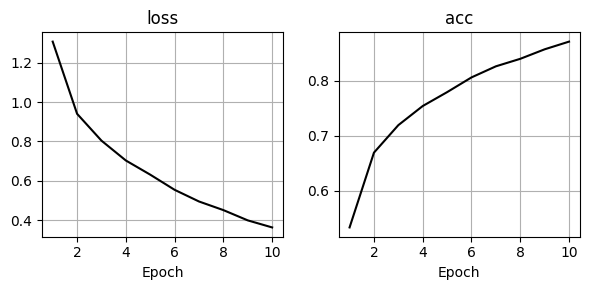

In [7]:
from common.utils import plot_history

plot_history(history["train"])